<a href="https://colab.research.google.com/github/PhilipOe1612340/CVIS_DeepLearning/blob/master/exercises_01/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/PhilipOe1612340/CVIS_DeepLearning.git
!pip install pillow
!pip install imageio

Cloning into 'CVIS_DeepLearning'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 45 (delta 10), reused 18 (delta 1), pack-reused 0
Unpacking objects: 100% (45/45), done.


In [0]:
import numpy as np
import imageio as imageIO
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
def vignetting(I, a):
    r = radius(I)
    s = poly(a, r)

    J = np.zeros(I.shape, np.float32)
    J[:, :, 0] = s * I[:, :, 0]
    J[:, :, 1] = s * I[:, :, 1]
    J[:, :, 2] = s * I[:, :, 2]
    return J


def poly(a, r):
    s = a[0] * np.ones_like(r)
    for deg in range(1, len(a)):
        s += a[deg] * (r ** deg)
    return s


def radius(I):
    W, H = (I.shape[1], I.shape[0])
    wc = W / 2
    hc = H / 2

    xv, yv = np.meshgrid(np.arange(W) - wc, np.arange(H) - hc)
    r = np.sqrt(xv ** 2 + yv ** 2) / np.sqrt(wc ** 2 + hc ** 2)
    return r


# image to W*H by 4 matrix
def I2X(I):
    W, H = (I.shape[1], I.shape[0])
    r = radius(I)

    X = np.zeros((W * H, 4), dtype=np.float32)
    X[:, 0] = np.ravel(I[:, :, 0])
    X[:, 1] = np.ravel(I[:, :, 1])
    X[:, 2] = np.ravel(I[:, :, 2])
    X[:, 3] = np.ravel(r)
    return X


def est(Xt, Dt, Xv, Dv, theta0, lam, learning_rate=0.0005, niter=100):
    theta = [tf.Variable(t) for t in theta0]

    x = tf.placeholder(tf.float32)
    d = tf.placeholder(tf.float32)

    st = poly(theta, Xt[:, 3])
    sv = poly(theta, Xv[:, 3])

    losst = (st * x[:, 0] - d[:, 0]) ** 2 + \
            (st * x[:, 1] - d[:, 1]) ** 2 + \
            (st * x[:, 2] - d[:, 2]) ** 2

    lossv = (sv * x[:, 0] - d[:, 0]) ** 2 + \
            (sv * x[:, 1] - d[:, 1]) ** 2 + \
            (sv * x[:, 2] - d[:, 2]) ** 2

    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train = optimizer.minimize(losst + (lam) * tf.reduce_sum([t ** 2 for t in theta]))
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    for t in range(niter):
        sess.run(train, {x: Xt, d: Dt})
        v_loss = sess.run(lossv, {x: Xv, d: Dv})
        # print(t,v_loss.sum(),sess.run([theta])[0])
    return sess.run(lossv, {x: Xv, d: Dv}).mean(), sess.run(losst, {x: Xt, d: Dt}).mean(), sess.run([theta])[0]


def devignetting(I, a):
    # compute vignetting factor on complete grid
    r = radius((I))
    s = poly(a, r)

    J = np.zeros(I.shape, np.float32)
    J[:, :, 0] = I[:, :, 0] / s
    J[:, :, 1] = I[:, :, 1] / s
    J[:, :, 2] = I[:, :, 2] / s
    return J

In [0]:
X = np.concatenate((I2X(imageIO.imread('CVIS_DeepLearning/exercises_01/code/cat_01.jpg')),
                    I2X(imageIO.imread('CVIS_DeepLearning/exercises_01/code/cat_02.jpg')),
                    I2X(imageIO.imread('CVIS_DeepLearning/exercises_01/code/cat_03.jpg'))), 0)

D = np.concatenate((I2X(imageIO.imread('CVIS_DeepLearning/exercises_01/code/cat_01_vignetted.jpg')),
                    I2X(imageIO.imread('CVIS_DeepLearning/exercises_01/code/cat_02_vignetted.jpg')),
                    I2X(imageIO.imread('CVIS_DeepLearning/exercises_01/code/cat_03_vignetted.jpg'))), 0)

0 0 17253.516 14430.607 [0.36596695]
0 1 9953.092 15586.802 [0.37446937]
0 2 11145.952 15749.258 [0.37041077]
0 3 13635.351 14976.041 [0.3736912]
0 4 24647.314 13795.704 [0.3384205]
1 0 15531.164 12323.318 [0.34868652, 0.16580299]
1 1 7940.577 13673.16 [0.35883987, 0.15878123]
1 2 9302.249 13670.698 [0.35478017, 0.16265064]
1 3 12076.895 12837.359 [0.35622722, 0.16756447]
1 4 21906.383 12015.164 [0.3238527, 0.15037791]
2 0 15206.355 11889.292 [0.34373653, 0.16264042, 0.08539514]
2 1 7442.4727 13314.173 [0.35456833, 0.15604253, 0.07890473]
2 2 8959.394 13229.824 [0.35037956, 0.15989096, 0.08350476]
2 3 11812.733 12391.579 [0.351214, 0.1643797, 0.08661653]
2 4 21351.016 11631.682 [0.3195352, 0.14757678, 0.0786363]
3 0 15131.911 11780.114 [0.34201777, 0.16145472, 0.08454912, 0.04818183]
3 1 7289.3086 13232.867 [0.35311878, 0.15503, 0.07817311, 0.04344853]
3 2 8886.449 13112.335 [0.34888142, 0.1588835, 0.08280662, 0.04705084]
3 3 11761.451 12277.817 [0.34948412, 0.16320027, 0.08578767, 0.0

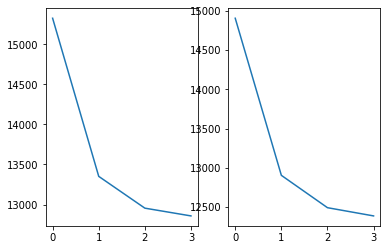

In [10]:

# randomly suffling the dataset
perm = np.random.permutation(X.shape[0])
perm = perm[1:100]
X = X[perm, :]
D = D[perm, :]
n = X.shape[0]
K = 5
nrange = list(range(1, 5))

chunk_length = int(n / K)

lossv = np.zeros((K, len(nrange)), dtype=np.float32)
losst = np.zeros((K, len(nrange)), dtype=np.float32)
for ni in range(len(nrange)):

    theta0 = np.zeros(nrange[ni], dtype=np.float32)

    for k in range(K):
        start = k * chunk_length
        stop = (k + 1) * chunk_length

        Xv = X[start:stop, :]
        Dv = D[start:stop, :]

        Xt = X[np.concatenate((np.arange(0, start), np.arange(stop + 1, n))), :]
        Dt = D[np.concatenate((np.arange(0, start), np.arange(stop + 1, n))), :]

        lossv[k, ni], losst[k, ni], thetan = est(Xt, Dt, Xv, Dv, theta0, 0, 0.000000001)

        print(ni, k, lossv[k, ni], losst[k, ni], thetan)
        np.save('lossv', lossv)
        np.save('losst', losst)

plt.subplot(1, 2, 1)
plt.plot(np.mean(lossv, 0))
plt.subplot(1, 2, 2)
plt.plot(np.mean(losst, 0))
plt.show()

74.3280839896471


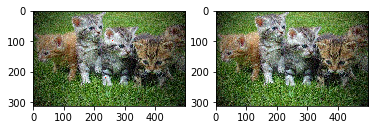

In [11]:

theta0 = np.zeros(20,dtype=np.float32)
_,_ , thetan = est(X, D, X, D, theta0, 0, 0.000000001,niter=1000)

X = np.concatenate((I2X(vignetting(imageIO.imread('CVIS_DeepLearning/exercises_01/code/cat_01.jpg'), thetan)),
                    I2X(vignetting(imageIO.imread('CVIS_DeepLearning/exercises_01/code/cat_02.jpg'), thetan)),
                    I2X(vignetting(imageIO.imread('CVIS_DeepLearning/exercises_01/code/cat_03.jpg'), thetan))), 0)

D = np.concatenate((I2X(imageIO.imread('CVIS_DeepLearning/exercises_01/code/cat_01_vignetted.jpg')),
                    I2X(imageIO.imread('CVIS_DeepLearning/exercises_01/code/cat_02_vignetted.jpg')),
                    I2X(imageIO.imread('CVIS_DeepLearning/exercises_01/code/cat_03_vignetted.jpg'))), 0)

standard_deviation = np.sqrt(np.sum((X[:, :-1] - D[:, :-1]) ** 2) / (D.shape[0] - 1))
print(standard_deviation)

plt.subplot(1, 2, 1)
plt.imshow(np.uint8(devignetting(imageIO.imread('CVIS_DeepLearning/exercises_01/code/cat_05_vignetted.jpg'), thetan)))
plt.subplot(1, 2, 2)
plt.imshow(np.uint8(imageIO.imread('CVIS_DeepLearning/exercises_01/code/cat_05_vignetted.jpg')))
plt.show()
